##Data preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Try to get data using Coinmarket API:

In [ ]:
#Since this API is not free, no data is returned.
#So, don't run it

key = '0774dc30-e003-4388-9697-e40bd431af1e'

url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
full_url = requests.get(url + "?start=20130428&limit=5000&convert=USD&CMC_PRO_API_KEY=" + key)

#Load locally stored csv with data from yahoo (BTC-USD since 9/14/2014):

In [3]:
import os
path = os.getcwd() 
bitcoin_market_info = pd.read_csv(path + "/exper_files/datasets/BTC-USD_yahoo.csv")

Convert 'Date' column to type 'datetime64'

In [23]:
bitcoin_market_info['Date'] = pd.to_datetime(bitcoin_market_info['Date'])

Some values are null, so lets fill them with the values of the previous day:

In [4]:
bitcoin_market_info.fillna(method='ffill', inplace=True)

Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:

In [5]:
kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
          'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])}

bitcoin_market_info = bitcoin_market_info.assign(**kwards)

#Split data

In [24]:
percent_train_set = 0.95
split_date = bitcoin_market_info.iloc[round(bitcoin_market_info.shape[0] * percent_train_set)]['Date']
training_set, test_set = bitcoin_market_info[bitcoin_market_info['Date'] < split_date], \
                         bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]


#Normalize inputs in windows

In [27]:
window_len = 10
LSTM_training_inputs = []
for i in range(len(training_set) - window_len):
    temp_set = training_set[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)

    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1

    LSTM_training_inputs.append(temp_set)

LSTM_training_outputs = (training_set['Close'][window_len:].values / training_set['Close'][:-window_len].values) - 1

LSTM_test_inputs = []
for i in range(len(test_set) - window_len):
    temp_set = test_set[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)

    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1

    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = (test_set['Close'][window_len:].values / test_set['Close'][:-window_len].values) - 1


Convert DataFrames to numpy arrays

In [28]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_input) for LSTM_test_input in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

##Define LSTM model

In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout


def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#Build and train LSTM model for one-day-ahead predictions

In [30]:
np.random.seed(202)

epochs = 20
batch_size = 1
neurons = 20

btcoin_model = build_model(LSTM_training_inputs, output_size=1, neurons=neurons)
hist = btcoin_model.fit(LSTM_training_inputs, LSTM_training_outputs,
                        epochs=epochs, batch_size=1, verbose=batch_size, shuffle=True)

Epoch 1/20
2283/2283 [==============================] - 10s 3ms/step - loss: 0.2782
Epoch 2/20
2283/2283 [==============================] - 9s 4ms/step - loss: 0.0940
Epoch 3/20
2283/2283 [==============================] - 6s 3ms/step - loss: 0.0939
Epoch 4/20
2283/2283 [==============================] - 6s 3ms/step - loss: 0.0956
Epoch 5/20
2283/2283 [==============================] - 6s 3ms/step - loss: 0.0925
Epoch 6/20
2283/2283 [==============================] - 9s 4ms/step - loss: 0.0955
Epoch 7/20
2283/2283 [==============================] - 10s 5ms/step - loss: 0.0930
Epoch 8/20
2283/2283 [==============================] - 10s 5ms/step - loss: 0.0908
Epoch 9/20
2283/2283 [==============================] - 10s 5ms/step - loss: 0.0908
Epoch 10/20
2283/2283 [==============================] - 10s 5ms/step - loss: 0.0940
Epoch 11/20
2283/2283 [==============================] - 10s 5ms/step - loss: 0.0908
Epoch 12/20
2283/2283 [==============================] - 10s 5ms/step - loss: 0

Plot MAE

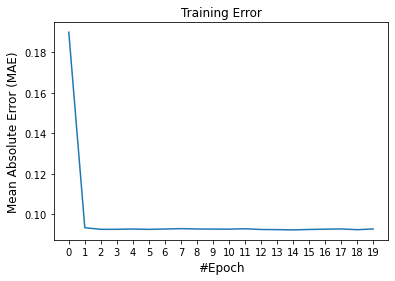

In [36]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(hist.epoch, hist.history['loss'])
ax1.set_xticks(range(0, len(hist.epoch)))
ax1.set_title('Training Error')
ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax1.set_xlabel('#Epoch', fontsize=12)
plt.show()

Plot predictions side-by-side with actual values for training set

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import datetime


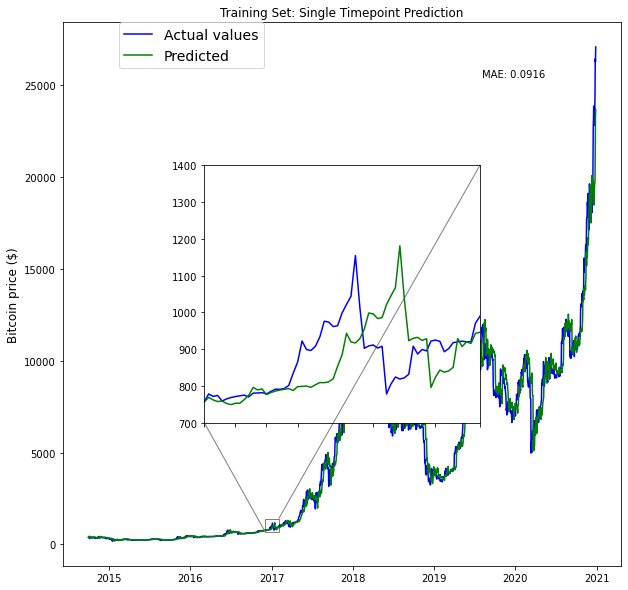

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

# Plot actual values
ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
         training_set['Close'][window_len:], label='Actual values', color='b')

# Plot predicted values
ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
         ((np.transpose(btcoin_model.predict(LSTM_training_inputs)) + 1) * training_set['Close'].values[:-window_len])[0],
         label='Predicted', color='g')

# Set plot title
ax1.set_title("Training Set: Single Timepoint Prediction")

# Set y label of plot
ax1.set_ylabel('Bitcoin price ($)', fontsize=12)

# Define bbox_to_anchor where MAE will be plotted
ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})

# Calculate and plot MAE
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(btcoin_model.predict(LSTM_training_inputs)) + 1) -
                                          (training_set['Close'].values[window_len:]) / (
                                              training_set['Close'].values[:-window_len]))),
             xy=(0.75, 0.9), xycoords='axes fraction',
             xytext=(0.75, 0.9), textcoords='axes fraction')

# Zoom in plot inside figure
axins = zoomed_inset_axes(ax1, 20., loc=10)  # Zoom_factor = 20., location = 10 (which means center)

axins.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
           training_set['Close'][window_len:], label='Actual values', color='b')

axins.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
           ((np.transpose(btcoin_model.predict(LSTM_training_inputs)) + 1) * training_set['Close'].values[:-window_len])[0],
           label='Predicted', color='g')

axins.set_xlim([datetime.date(2016, 12, 1), datetime.date(2017, 2, 1)])
axins.set_ylim([700, 1400])
axins.set_xticklabels('')

mark_inset(ax1, axins, loc1=1, loc2=3, fc='none', ec='0.5')
plt.show()

Plot predictions side-by-side with actual values for test set

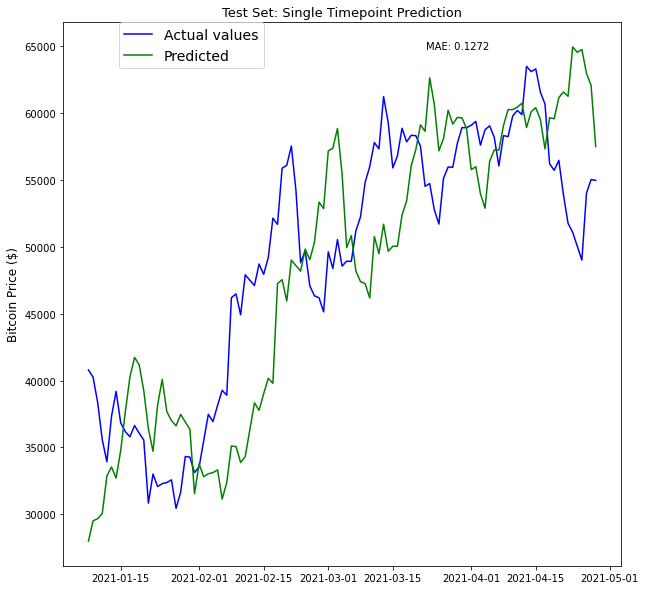

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['Date'][window_len:]),
         test_set['Close'][window_len:], label='Actual values', color='b')

ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['Date'][window_len:]),
         ((np.transpose(btcoin_model.predict(LSTM_test_inputs)) + 1) * test_set['Close'].values[:-window_len])[0],
         label='Predicted', color='g')

ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(btcoin_model.predict(LSTM_test_inputs)) + 1) - \
                                          (test_set['Close'].values[window_len:]) / (test_set['Close'].values[:-window_len]))),
             xy=(0.65, 0.95), xycoords='axes fraction',
             xytext=(0.65, 0.95), textcoords='axes fraction')

ax1.set_title('Test Set: Single Timepoint Prediction', fontsize=13)

ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)

plt.show()

#Build and train LSTM model for 5-days-ahead predictions

Normalize training outputs: 5 next prices normalized to 10th previous closing price

In [49]:
pred_range = 5

LSTM_ranged_training_outputs = []
for i in range(window_len, len(training_set['Close']) - pred_range):
    LSTM_ranged_training_outputs.append((training_set['Close'][i:i+pred_range].values/training_set['Close'][i-window_len]) - 1)

LSTM_ranged_training_outputs = np.array(LSTM_ranged_training_outputs)

Build the model

In [51]:
neurons = 20

ranged_btcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons)

Train the model

In [52]:
np.random.seed(202)

epochs = 20
batch_size = 1

ranged_hist = ranged_btcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs,
                                      epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True)


Epoch 1/20
2278/2278 - 11s - loss: 0.1741
Epoch 2/20
2278/2278 - 9s - loss: 0.1034
Epoch 3/20
2278/2278 - 7s - loss: 0.1029
Epoch 4/20
2278/2278 - 7s - loss: 0.1029
Epoch 5/20
2278/2278 - 7s - loss: 0.1026
Epoch 6/20
2278/2278 - 9s - loss: 0.1031
Epoch 7/20
2278/2278 - 9s - loss: 0.1030
Epoch 8/20
2278/2278 - 9s - loss: 0.1027
Epoch 9/20
2278/2278 - 9s - loss: 0.1029
Epoch 10/20
2278/2278 - 7s - loss: 0.1030
Epoch 11/20
2278/2278 - 9s - loss: 0.1025
Epoch 12/20
2278/2278 - 9s - loss: 0.1030
Epoch 13/20
2278/2278 - 9s - loss: 0.1028
Epoch 14/20
2278/2278 - 9s - loss: 0.1029
Epoch 15/20
2278/2278 - 9s - loss: 0.1031
Epoch 16/20
2278/2278 - 9s - loss: 0.1030
Epoch 17/20
2278/2278 - 9s - loss: 0.1028
Epoch 18/20
2278/2278 - 9s - loss: 0.1026
Epoch 19/20
2278/2278 - 9s - loss: 0.1025
Epoch 20/20
2278/2278 - 9s - loss: 0.1031


#Get predictions and reformat array

In [54]:
pred_prices = (ranged_btcoin_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range] + 1) *\
              test_set['Close'].values[:-(window_len + pred_range)][::pred_range].reshape(int(np.ceil((len(LSTM_test_inputs) -
                                                                                            pred_range)/float(pred_range))), 1)


#Plot predictions side-by-side with actual values

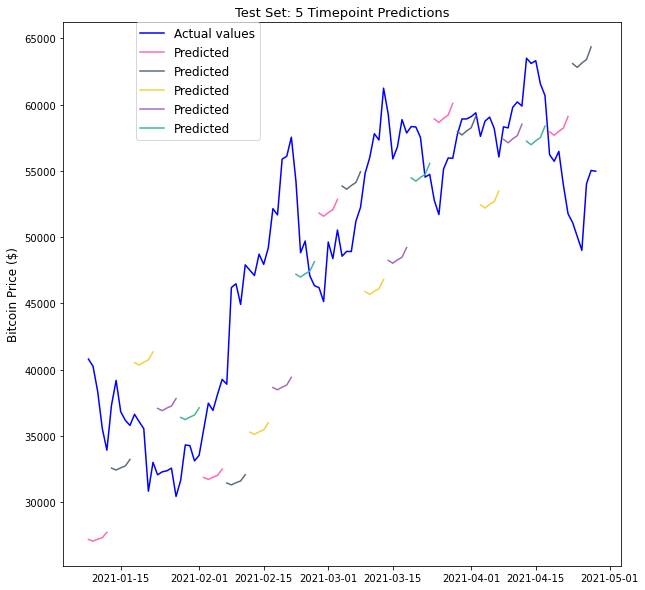

In [57]:
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['Date'][window_len:]),
         test_set['Close'][window_len:], label='Actual values', color='b')

for i, pred in enumerate(pred_prices):

    if i < pred_range: #Print label=predicted for the first time

        ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['Date'][window_len:])[(i * pred_range):((i * pred_range) + pred_range)],
                 pred, color=pred_colors[i % pred_range], label='Predicted')

    else: #Dont print label=predicted again

        ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['Date'][window_len:])[
                 (i * pred_range):((i * pred_range) + pred_range)],
                 pred, color=pred_colors[i % pred_range])

ax1.set_title('Test Set: 5 Timepoint Predictions', fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
plt.show()

##Try to make predictions for earliest period:

Keep data for a specific date and before:

In [79]:
spec_date = pd.to_datetime('2017-11-01')

spec_date_bitcoin_market_info = bitcoin_market_info[bitcoin_market_info['Date'] <= spec_date]

Split data:

In [80]:
def split_data(perc_train_set, currency_data):
        
        splt_date = currency_data.iloc[round(currency_data.shape[0] * perc_train_set)]['Date']
        tr_set, tst_set = currency_data[currency_data['Date'] < splt_date], \
                         currency_data[currency_data['Date'] >= splt_date]
        
        return tr_set, tst_set


In [81]:
percent_train_set = 0.95

training_set, test_set = split_data(percent_train_set, spec_date_bitcoin_market_info)

Normalize training inputs and outputs:

In [82]:
def norm_train_test_in_out(prd_range, wind_len, tr_set, tst_set):
    
    LSTM_tr_in = []
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        tmp_set = tmp_set.drop(['Date'], axis=1)

        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1

        LSTM_tr_in.append(tmp_set)
    
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    LSTM_test_in = []
    for i in range(len(tst_set) - wind_len):
        tmp_set = tst_set[i:(i + wind_len)].copy()
        tmp_set = tmp_set.drop(['Date'], axis=1)

        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1

        LSTM_test_in.append(tmp_set)
        
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(tr_set['Close']) - prd_range):
        LSTM_rangd_train_out.append((tr_set['Close'][i:i+prd_range].values/tr_set['Close'][i-wind_len]) - 1)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    return LSTM_rangd_train_out, LSTM_tr_in, LSTM_test_in

In [83]:
pred_range = 5
window_len = 10

LSTM_ranged_training_outputs, LSTM_training_inputs, LSTM_test_inputs = norm_train_test_in_out(pred_range, window_len, 
                                                                                              training_set, test_set)

Bulid and train model:

In [84]:
def build_and_train_model(epchs, btch_size, neurs, prd_range, LSTM_train_in, LSTM_rangd_train_out, shffl):

    rnged_btcoin_model = build_model(LSTM_train_in, output_size=prd_range, neurons=neurs)
    
    np.random.seed(202)

    rnged_hist = rnged_btcoin_model.fit(LSTM_train_in[:-prd_range], LSTM_rangd_train_out,
                                      epochs=epchs, batch_size=btch_size, verbose=1, shuffle=shffl)
    
    return rnged_btcoin_model, rnged_hist

In [78]:
epochs = 20
batch_size = 1
neurons = 20
shuffle = True

ranged_btcoin_model, ranged_hist = build_and_train_model(epochs, batch_size, neurons, pred_range, LSTM_training_inputs,
                                                        LSTM_ranged_training_outputs, True)

ValueError: Data cardinality is ambiguous:
  x sizes: 2278
  y sizes: 1068, 1073, 47
Make sure all arrays contain the same number of samples.